# Notebook 2: Use GraphStorm APIs for Building a Link Prediction Pipeline

This notebook demonstrates how to use GraphStorm's APIs to create a graph machine learning pipeline for a link prediction task.

In this notebook, we modify the RGCN model used in the Notebook 1 to adapt to link prediction tasks and use it to conduct link prediction on the ACM dataset created by the **Notebook_0_Data_Prepare**. 

### Prerequsites

- GraphStorm. Please find [more details on installation of GraphStorm](https://graphstorm.readthedocs.io/en/latest/install/env-setup.html#setup-graphstorm-with-pip-packages).
- ACM data that has been created according to the [Notebook 0: Data Prepare](https://graphstorm.readthedocs.io/en/latest/notebooks/Notebook_0_Data_Prepare.html), and is stored in the `./acm_gs_1p/` folder.
- Installation of supporting libraries, e.g., matplotlib.

In [1]:
# Setup log level in Jupyter Notebook
import logging
logging.basicConfig(level=20)

---
The major steps of creating a link prediction pipeline are same as the node classification pipeline in the Notebook 1. In this notebook, we will only highlight the different components for clarity.

### 0. Initialize the GraphStorm Standalone Environment

In [2]:
import graphstorm as gs
gs.initialize()

/home/ec2-user/anaconda3/envs/gsf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Setup GraphStorm Dataset and DataLoaders


In [3]:
nfeats_4_modeling = {'author':['feat'], 'paper':['feat'],'subject':['feat']}

# create a GraphStorm Dataset for the ACM graph data generated in the Notebook 0
acm_data = gs.dataloading.GSgnnData(part_config='./acm_gs_1p/acm.json', node_feat_field=nfeats_4_modeling)

Because link prediction needs both positive and negative edges for training, we use GraphStorm's `GSgnnLinkPredictionDataloader` which is dedicated for link prediction dataloading. This class takes some common arugments as these `NodePredictionDataloader`s, such as `dataset`, `target_idx`, `node_feats`, and `batch_size`. It also takes some link prediction-related arguments, e.g., `num_negative_edges`, `exlude_training_targets`, and etc.

In [4]:
# define dataloaders for training and validation
train_dataloader = gs.dataloading.GSgnnLinkPredictionDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_edge_train_set(etypes=[('paper', 'citing', 'paper')]),
    fanout=[20, 20],
    num_negative_edges=10,
    node_feats=nfeats_4_modeling,
    batch_size=64,
    exclude_training_targets=True,
    reverse_edge_types_map={("paper", "citing", "paper"):("paper","cited","paper")},
    train_task=True)
val_dataloader = gs.dataloading.GSgnnLinkPredictionTestDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_edge_val_set(etypes=[('paper', 'citing', 'paper')]),
    fanout=[100, 100],
    num_negative_edges=100,
    node_feats=nfeats_4_modeling,
    batch_size=256)
test_dataloader = gs.dataloading.GSgnnLinkPredictionTestDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_edge_test_set(etypes=[('paper', 'citing', 'paper')]),
    fanout=[100, 100],
    num_negative_edges=100,
    node_feats=nfeats_4_modeling,
    batch_size=256)

INFO:root:part 0, train 24631
INFO:root:part 0, val 3078
INFO:root:part 0, test 3078


### 2. Create a GraphStorm-compatible RGCN Model for Link Prediction 

For the link prediction task, we modified the RGCN model used for node classification to adopt to link prediction task. Users can find the details in the `demon_models.py` file.

In [5]:
# import a simplified RGCN model for node classification
from demo_models import RgcnLPModel

model = RgcnLPModel(g=acm_data.g,
                    num_hid_layers=2,
                    node_feat_field=nfeats_4_modeling,
                    hid_size=128)

### 3. Setup a GraphStorm Evaluator

Here we change evaluator to a `GSgnnMrrLPEvaluator` that uses "mrr" as the metric dedicated for evaluation of link prediction performance.

In [6]:
# setup a link prediction evaluator for the trainer
evaluator = gs.eval.GSgnnMrrLPEvaluator(eval_frequency=1000)

### 4. Setup a Trainer and Training

GraphStorm has the `GSgnnLinkPredictionTrainer` for link prediction training loop. The way of constructing this trainer and calling `fit()` method are same as the `GSgnnNodePredictionTrainer` used in the Notebook 1.

In [7]:
# create a GraphStorm link prediction task trainer for the RGCN model
trainer = gs.trainer.GSgnnLinkPredictionTrainer(model, topk_model_to_save=1)
trainer.setup_evaluator(evaluator)
trainer.setup_device(gs.utils.get_device())

In [8]:
# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            test_loader=test_dataloader,
            num_epochs=50,
            save_model_path='a_save_path/',
            save_model_frequency=1000,
            use_mini_batch_infer=True)

/home/ec2-user/anaconda3/envs/gsf/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
INFO:root:Epoch 00000 | Batch 000 | Train Loss: 0.7259 | Time: 0.1481
INFO:root:Epoch 00000 | Batch 020 | Train Loss: 0.6885 | Time: 0.1065
INFO:root:Epoch 00000 | Batch 040 | Train Loss: 0.6860 | Time: 0.1038
INFO:root:Epoch 00000 | Batch 060 | Train Loss: 0.6880 | Time: 0.1019
INFO:root:Epoch 00000 | Batch 080 | Train Loss: 0.6839 | Time: 0.1012
INFO:root:Epoch 00000 | Batch 100 | Train Loss: 0.6780 | Time: 0.1010
INFO:root:Epoch 00000 | Batch 120 | Train Loss: 0.6791 | Time: 0.1120
INFO:root:Epoch 00000 | Batch 140 | Train Loss: 0.6721 | Time: 0.1009
INFO:

### (Optional) 5. Visualize Model Performance History

Same as the node classification pipeline, we can use the history stored in the evaluator.

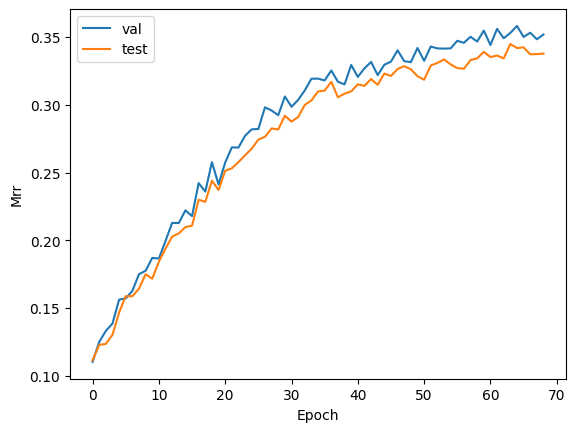

In [9]:
import matplotlib.pyplot as plt

# extract evaluation history of metrics from the trainer's evaluator:
val_metrics, test_metrics = [], []
for val_metric, test_metric in trainer.evaluator.history:
    val_metrics.append(val_metric['mrr'])
    test_metrics.append(test_metric['mrr'])

# plot the performance curves
fig, ax = plt.subplots()
ax.plot(val_metrics, label='val')
ax.plot(test_metrics, label='test')
ax.set(xlabel='Epoch', ylabel='Mrr')
ax.legend(loc='best')

### 6. Inference with the Trained Model

The operations of model restore are same as those used in the Notebook 1. Users can find the best model path first, and use model's `restore_model()` to load the trained model file.

In [10]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model path:', best_model_path)

Best model path: a_save_path/epoch-46


In [11]:
# we can restore the model from the saved path using the model's restore_model() function.
model.restore_model(best_model_path)

INFO:root:successfully load the model from a_save_path/epoch-46
INFO:root:Time on load model: 0.004 seconds


To do inference, users can either create a new dataloader as the following code does, or reuse one of the dataloaders defined in training.

In [12]:
# Setup dataloader for inference
infer_dataloader = gs.dataloading.GSgnnLinkPredictionTestDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_edge_infer_set(etypes=[('paper', 'citing', 'paper')]),
    fanout=[100, 100],
    num_negative_edges=100,
    node_feats=nfeats_4_modeling,
    batch_size=256)

Now we can define a `GSgnnLinkPredictionInferrer` by giving the restored model and do inference by calling its `infer()` method.

In [13]:
# Create an Inferrer object
infer = gs.inference.GSgnnLinkPredictionInferrer(model)

# Run inference on the inference dataset
infer.infer(acm_data,
            infer_dataloader,
            save_embed_path='infer/embeddings',
            use_mini_batch_infer=True)

INFO:root:[Rank 0] dist inference: finishes 0 iterations.
INFO:root:save embeddings of author to infer/embeddings
INFO:root:save embeddings of paper to infer/embeddings
INFO:root:save embeddings of subject to infer/embeddings
INFO:root:Writing GNN embeddings to infer/embeddings in pytorch format.


For link prediction task, the inference outputs are embeddings of all nodes in the inference graph.

In [14]:
# The GNN embeddings of all nodes in the inference graph are saved to the folder named after the target_ntype
!ls -lh infer/embeddings/paper

total 6.3M
-rw-rw-r-- 1 ec2-user ec2-user 6.2M Jul 12 00:01 embed-00000.pt
-rw-rw-r-- 1 ec2-user ec2-user  99K Jul 12 00:01 embed_nids-00000.pt
